In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from metrics_features import fi_perm
from dnn_tau import Dnn_tau
from data_extractor import Data_extractor_v2, output_vars_v2
import os
import fnmatch
from utils import normalize, bucketize, split_dataset
from copy import deepcopy
import pickle
from metrics_features import *

In [2]:
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST9/"
features = deepcopy(output_vars_v2)
features.extend(['signal_label', 'channel', 'event_type', 'mass_hyp'])
channels = os.listdir(path)
relative_path = "/anatuple/"

In [3]:
values = []
for i in range(len(features)):
    values.append([])
data = dict(zip(features, values))

for channel in channels:
    extractor = Data_extractor_v2(channel)
    data = extractor(path+channel+relative_path, data=data)

tte
selection done
2910
event
genWeight
reached var  deltaphi_12
reached var  deltaphi_13
reached var  deltaphi_23
reached var  deltaeta_12
reached var  deltaeta_13
reached var  deltaeta_23
reached var  deltaR_12
reached var  deltaR_13
reached var  deltaR_23
reached var  pt_123
reached var  mt_12
reached var  mt_13
reached var  mt_23
reached var  Mt_tot
reached var  n_tauh
tte
selection done
13
event
genWeight
reached var  deltaphi_12
reached var  deltaphi_13
reached var  deltaphi_23
reached var  deltaeta_12
reached var  deltaeta_13
reached var  deltaeta_23
reached var  deltaR_12
reached var  deltaR_13
reached var  deltaR_23
reached var  pt_123
reached var  mt_12
reached var  mt_13
reached var  mt_23
reached var  Mt_tot
reached var  n_tauh
tte
selection done
1599
event
genWeight
reached var  deltaphi_12
reached var  deltaphi_13
reached var  deltaphi_23
reached var  deltaeta_12
reached var  deltaeta_13
reached var  deltaeta_23
reached var  deltaR_12
reached var  deltaR_13
reached var  d

In [4]:
N = len(data['event'])
n_bkg = N-sum([data['signal_label'][i] for i in range(len(data['signal_label']))])
data_norm = normalize(pd.DataFrame(data), 'mass_hyp', n_bkg)
data_norm = normalize(data_norm, 'signal_label', n_bkg)
data_norm = normalize(data_norm, 'channel', n_bkg)
data_processed, channel_indices = bucketize(data_norm, 'channel')
print(list(data_processed.keys()))
print(channel_indices)

['event', 'genWeight', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'signal_label', 'channel', 'event_type', 'mass_hyp']
{'tte': 0, 'tee': 1, 'tmm': 2, 'tem': 3, 'ttm': 4}


In [5]:
input_vars = ['deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaR_12', 'deltaR_13', 'deltaR_23',
              'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'signal_label', 'channel', 'mass_hyp']

In [6]:
train, val, test, meas = split_dataset(data_processed)

Total number of events :  1610653
Train set : 37.52 %
Validation set : 12.51 %
Test set : 25.00 %
Measurement set : 24.98 %


In [7]:
extracted_data_path = "extracted_data/TEST9_global_v2_"
train.to_pickle(extracted_data_path+"train")
test.to_pickle(extracted_data_path+"test")
val.to_pickle(extracted_data_path+"val")
meas.to_pickle(extracted_data_path+"meas")

In [8]:
extracted_data_path = "extracted_data/TEST9_global_v2_"
train = pd.read_pickle(extracted_data_path+"train")
test = pd.read_pickle(extracted_data_path+"test")
val = pd.read_pickle(extracted_data_path+"val")
meas = pd.read_pickle(extracted_data_path+"meas")

input_vars = ['deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaR_12', 'deltaR_13', 'deltaR_23',
              'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'signal_label', 'channel', 'mass_hyp']

x_train = train[input_vars]
x_test = test[input_vars]
x_val = val[input_vars]
x_meas = meas[input_vars]

label_train = x_train.pop('signal_label').astype(float)
label_val = x_val.pop('signal_label').astype(float)
label_test = x_test.pop('signal_label').astype(float)
label_meas = x_meas.pop('signal_label').astype(float)

learning_features = list(x_train.keys())

In [11]:
depths = [len(learning_features)*2]*5
print(depths)
model = Dnn_tau(list(x_train.keys()), widths=depths)
model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['MSE', 'accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./saved_models/checkpoint",
    monitor = "val_loss",
    save_best_only = True
)
history = model.fit(x_train, label_train, sample_weight=train['genWeight'], validation_data=(x_val, label_val), epochs=100000, verbose=1, 
                    batch_size = 400, callbacks=[early_stopping, checkpoint])
model = tf.keras.models.load_model('./saved_models/checkpoint')
model.save('./saved_models/TEST9_global_v2')
# Save history
filename = "./saved_history/TEST9_global_vs.pkl"
with open(filename, "wb") as file:
    pickle.dump(history.history, file)

[32, 32, 32, 32, 32]
Epoch 1/100000
1509/1511 [============================>.] - ETA: 0s - loss: 3.2059 - MSE: 0.3568 - accuracy: 0.5298

KeyboardInterrupt: 

In [3]:
model = tf.keras.models.load_model('./saved_models/TEST9_global_v2')

2023-05-01 14:33:08.594909: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 14:33:09.492643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-05-01 14:33:09.493547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [5]:
print(model.metrics_names)

[]


In [5]:
delta_loss_perm = []
loss_no_shuffle = fi_perm(model, test, input_vars, [])
for key in learning_features:
    loss_shuffle = fi_perm(model, test, input_vars, key)
    delta_loss_perm.append(loss_shuffle-loss_no_shuffle)
delta_loss_perm = dict(zip(learning_features, delta_loss_perm))
print(delta_loss_perm)

x_test defined
y_test defined
Loss with shuffle evaluated
x_test defined
y_test defined
0    0.619110
1    0.510193
2    1.376953
3    0.476545
4    2.452375
5    2.357056
6    0.287598
7    0.482910
8    2.813477
9    0.016235
Name: deltaphi_12, dtype: float64
0    2.343262
1    0.343262
2    1.180542
3    1.886701
4    1.627441
5    1.762433
6    1.044800
7    0.361206
8    2.951660
9    2.946777
Name: deltaphi_12, dtype: float64
permutated x_test defined
Loss with shuffle evaluated
x_test defined
y_test defined
0    0.387207
1    2.619812
2    1.838745
3    2.605133
4    0.611328
5    2.549561
6    2.984357
7    2.852399
8    2.425031
9    1.274292
Name: deltaphi_13, dtype: float64
0    2.636213
1    0.272949
2    0.893677
3    1.065918
4    1.003174
5    2.407575
6    1.745832
7    2.668213
8    0.846174
9    2.796906
Name: deltaphi_13, dtype: float64
permutated x_test defined
Loss with shuffle evaluated
x_test defined
y_test defined
0    1.006317
1    2.109619
2    3.067487
3    3

In [7]:
filename = "./saved_results/TEST9_global_v1_loss_shuffle.pkl"
with open(filename, "wb") as file:
    pickle.dump(delta_loss_perm, file)

In [8]:
filename = "./saved_results/TEST9_global_v1_loss_shuffle.pkl"
with open(filename, "rb") as f:
    delta_loss_perm = pickle.load(f)

In [20]:
for key in delta_loss_perm:
    print(key, "  \t: {:.5f}".format(delta_loss_perm[key]))

deltaphi_12   	: 0.00105
deltaphi_13   	: 0.00078
deltaphi_23   	: 0.00094
deltaeta_12   	: 0.01099
deltaeta_13   	: 0.01067
deltaeta_23   	: 0.00377
deltaR_12   	: 0.00212
deltaR_13   	: 0.00176
deltaR_23   	: 0.00179
pt_123   	: 0.07949
mt_12   	: 0.07728
mt_13   	: 0.03374
mt_23   	: 0.16063
Mt_tot   	: 0.87094
channel   	: 0.63062
mass_hyp   	: 4.22326


In [21]:
from metrics_features import fi_mutual_info
mis = fi_mutual_info(model, test, input_vars)

/usr/local/miniconda3/envs/tau-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Results of the file compute_feature_importance.py

In [4]:
data = pd.read_pickle("extracted_data/TEST9_global_v4_all_normalized")
with open('extracted_data/TEST9_global_v4_all_normalized_channel_indices', 'rb') as file:
    channel_indices = pickle.load(file)

In [5]:
learning_features = ['charge_1', 'charge_2', 'charge_3', 'pt_1',
       'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2',
       'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET',
       'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)',
       'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)',
       'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)',
       'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)',
       'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23',
       'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12',
       'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)',
       'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET',
       'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)',
       'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)',
       'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'mass_12', 'mass_13',
       'mass_23', 'mass_123', 'Mt_tot', 'HNL_CM_angle_with_MET_1',
       'HNL_CM_angle_with_MET_2', 'W_CM_angle_to_plane_1',
       'W_CM_angle_to_plane_2', 'W_CM_angle_to_plane_with_MET_1',
       'W_CM_angle_to_plane_with_MET_2', 'HNL_CM_mass_1', 'HNL_CM_mass_2',
       'HNL_CM_mass_with_MET_1', 'HNL_CM_mass_with_MET_2', 'W_CM_angle_12',
       'W_CM_angle_13', 'W_CM_angle_23', 'W_CM_angle_1MET', 'W_CM_angle_2MET',
       'W_CM_angle_3MET', 'mass_hyp']
selection = learning_features+['signal_label']

In [9]:
depths = [5,7,10,15]

Total number of events :  62910
Train set : 37.43 %
Validation set : 12.48 %
Test set : 25.06 %
Measurement set : 25.04 %
62910
493/493 [==============================] - 2s 4ms/step - loss: 1.2138 - accuracy: 0.3697


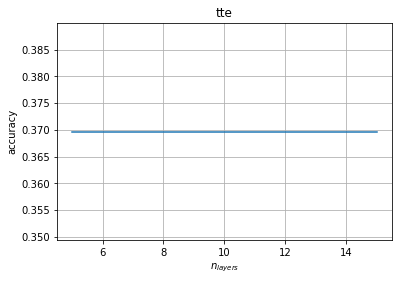

Total number of events :  332468
Train set : 37.50 %
Validation set : 12.50 %
Test set : 24.96 %
Measurement set : 25.04 %
332468
2594/2594 [==============================] - 11s 4ms/step - loss: 0.3806 - accuracy: 0.7912


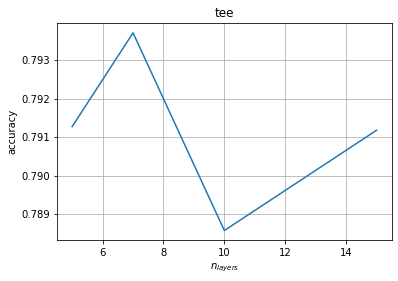

Total number of events :  679219
Train set : 37.54 %
Validation set : 12.51 %
Test set : 24.97 %
Measurement set : 24.98 %
679219
5300/5300 [==============================] - 23s 4ms/step - loss: 0.4064 - accuracy: 0.7818


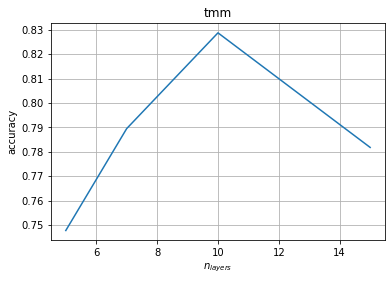

Total number of events :  281046
Train set : 37.55 %
Validation set : 12.52 %
Test set : 25.00 %
Measurement set : 24.93 %
281046
2196/2196 [==============================] - 10s 4ms/step - loss: 1.2241 - accuracy: 0.4390


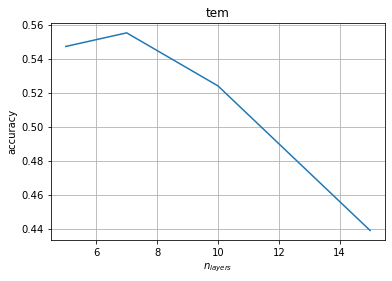

Total number of events :  255010
Train set : 37.48 %
Validation set : 12.49 %
Test set : 25.09 %
Measurement set : 24.93 %
255010
2000/2000 [==============================] - 9s 4ms/step - loss: 1.1565 - accuracy: 0.5192


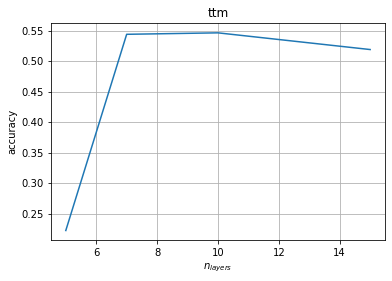

In [11]:
import matplotlib.pyplot as plt

for channel in channel_indices:
    data_channel = data.loc[data['channel'] == channel_indices[channel]]
    train, val, test, meas = split_dataset(data_channel)
    print(len(data_channel['event']))
    x = test[selection]
    y = x.pop('signal_label')

    accuracies = []
    for depth in depths:
        model = tf.keras.models.load_model('saved_models/TEST9_global_v4_{}_depth_{}'.format(channel, depth))
        _, accuracy = model.evaluate(x, y)
        accuracies.append(accuracy)
    
    plt.plot(depths, accuracies)
    plt.xlabel('$n_{layers}$')
    plt.ylabel('accuracy')
    plt.title(channel)
    plt.grid()
    plt.show()


In [16]:
for channel in channel_indices:
    print(channel, ":")
    with open('saved_results/TEST9_global_v4_loss_shuffle_' + channel, 'rb') as file:
        fi = pickle.load(file)
    for key in fi:
        print("\t-", key, "  \t: {:.5f}".format(fi[key][0]))
    

tte :
	- charge_1   	: -0.00000
	- charge_2   	: 0.00002
	- charge_3   	: 0.00007
	- pt_1   	: 0.02060
	- pt_2   	: 0.01068
	- pt_3   	: 0.04956
	- pt_MET   	: 0.02304
	- eta_1   	: -0.00029
	- eta_2   	: -0.00014
	- eta_3   	: -0.00004
	- mass_1   	: 0.00001
	- mass_2   	: 0.00001
	- mass_3   	: 0.00001
	- deltaphi_12   	: 0.00067
	- deltaphi_13   	: 0.00002
	- deltaphi_23   	: 0.00009
	- deltaphi_1MET   	: 0.00012
	- deltaphi_2MET   	: 0.00019
	- deltaphi_3MET   	: 0.00053
	- deltaphi_1(23)   	: 0.00103
	- deltaphi_2(13)   	: 0.00017
	- deltaphi_3(12)   	: -0.00010
	- deltaphi_MET(12)   	: 0.00014
	- deltaphi_MET(13)   	: 0.00018
	- deltaphi_MET(23)   	: 0.00036
	- deltaphi_1(2MET)   	: 0.00112
	- deltaphi_1(3MET)   	: -0.00003
	- deltaphi_2(1MET)   	: 0.00085
	- deltaphi_2(3MET)   	: 0.00016
	- deltaphi_3(1MET)   	: 0.00010
	- deltaphi_3(2MET)   	: 0.00014
	- deltaeta_12   	: 0.00006
	- deltaeta_13   	: 0.00009
	- deltaeta_23   	: 0.00010
	- deltaeta_1(23)   	: 0.00002
	- deltaeta_2

pandas.core.frame.DataFrame

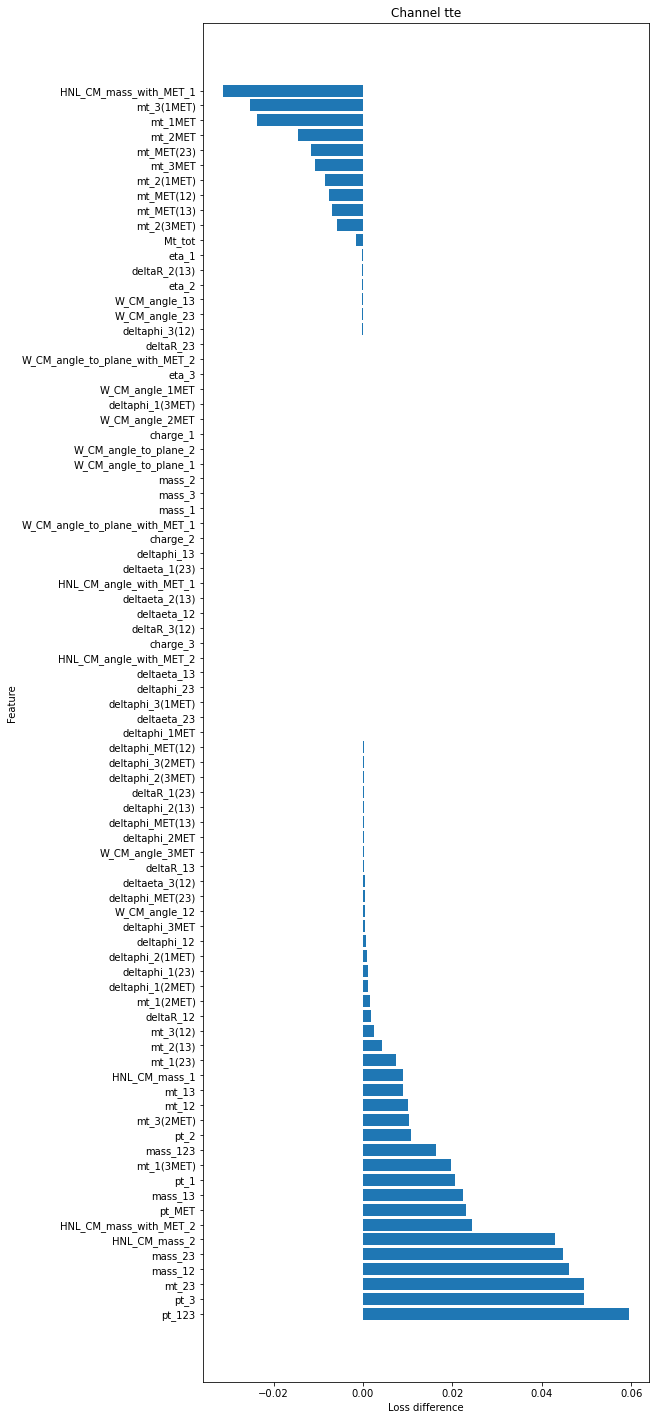

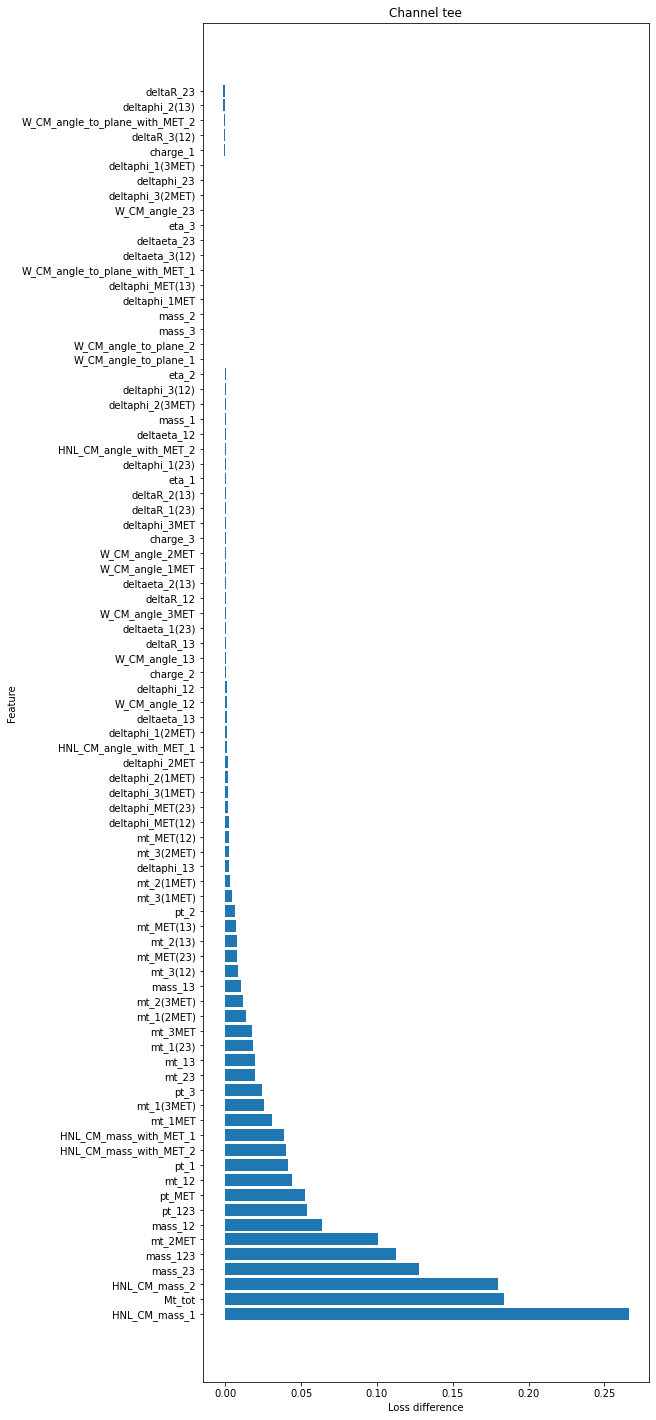

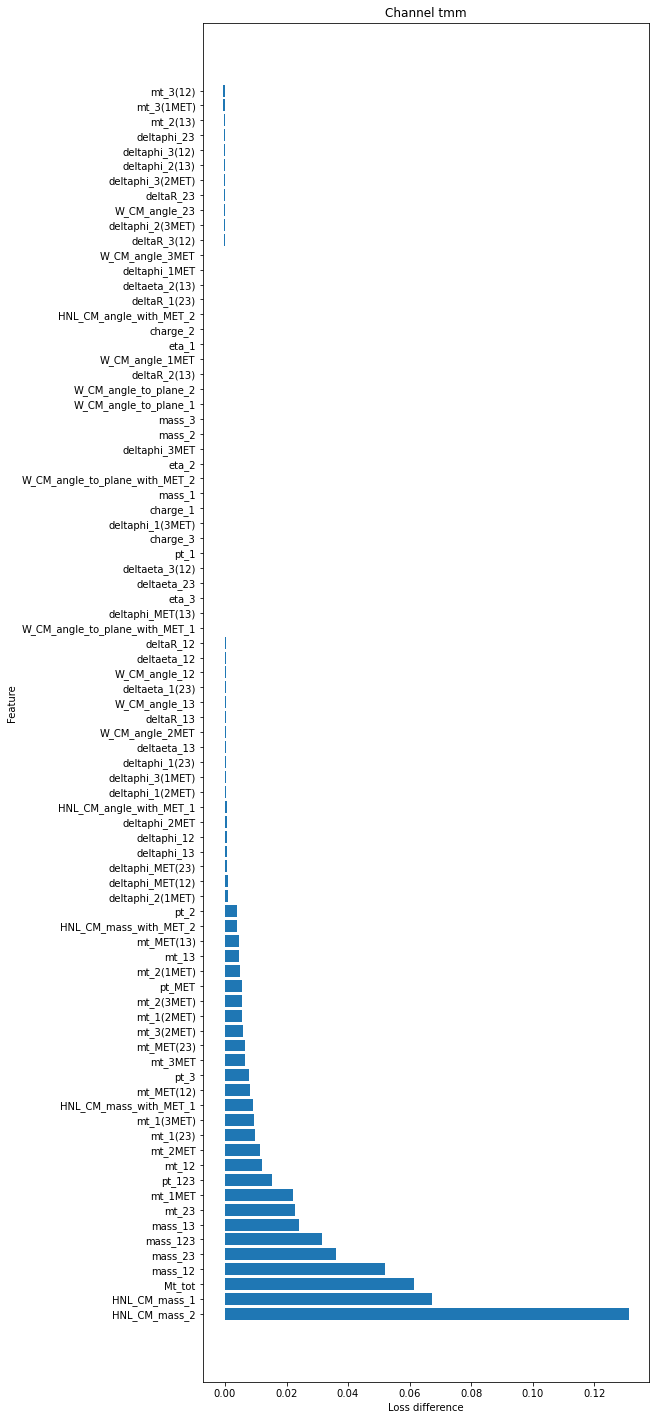

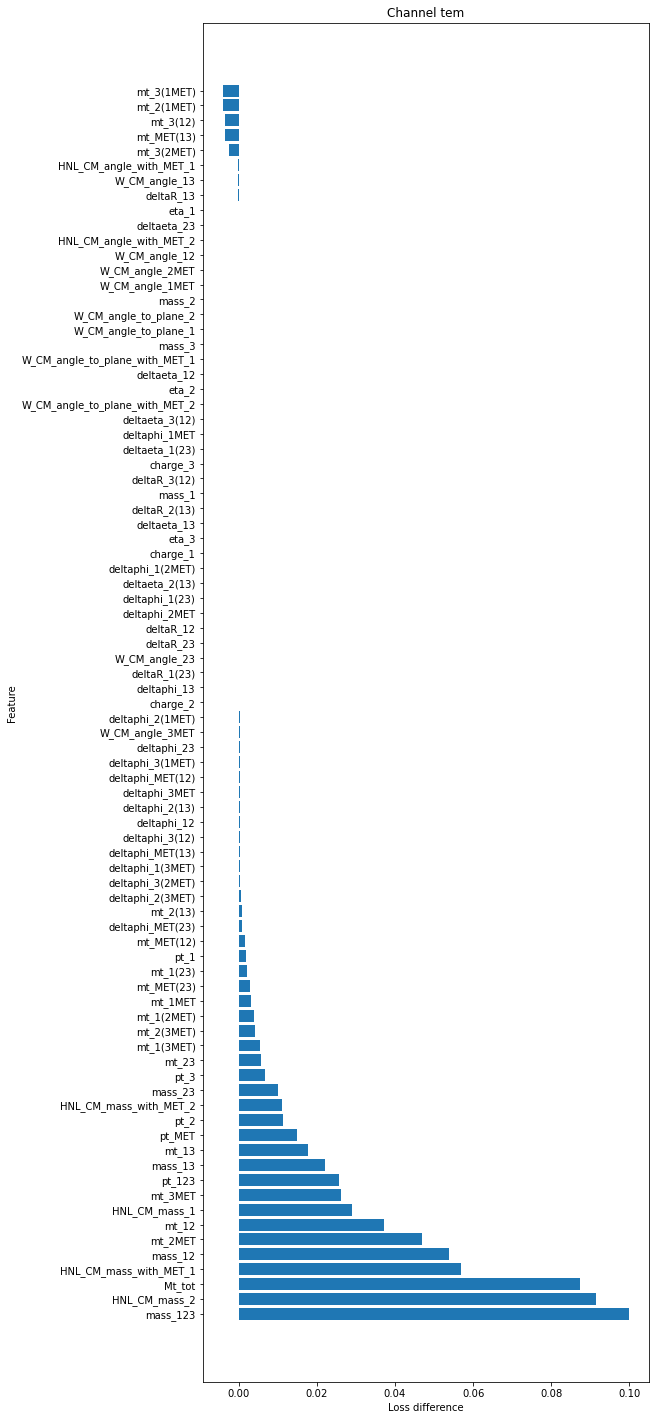

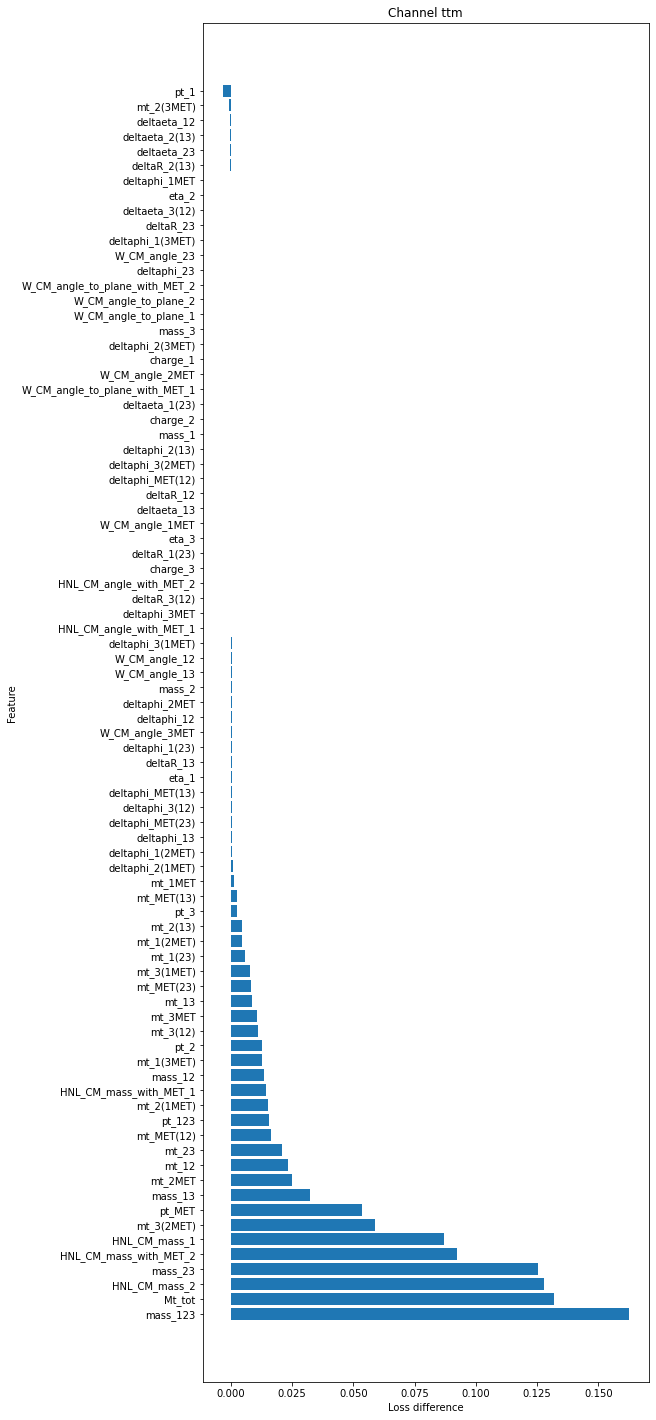

In [34]:
import matplotlib.pyplot as plt

for channel in channel_indices:

    with open('saved_results/TEST9_global_v4_loss_shuffle_' + channel, 'rb') as file:
        fi = pickle.load(file)
    try:
        sorted_fi = sorted(fi.items(), key=lambda x: x[1], reverse=True)
        names = [item[0] for item in sorted_fi]
        values = [item[1][0] for item in sorted_fi]
    except:
        fi = fi.to_dict(orient='records')[0]
        sorted_fi = sorted(fi.items(), key=lambda x: x[1], reverse=True)
        names = [item[0] for item in sorted_fi]
        values = [item[1] for item in sorted_fi]
    
    plt.figure(figsize=(8, 25))
    plt.barh(names[1:], values[1:])
    plt.xlabel('Loss difference')
    plt.ylabel('Feature')
    plt.title('Channel ' + channel)
    plt.show()